In [1]:
import numpy as np
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, LineString
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import radians, cos, sin, sqrt, atan2
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
import folium
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Distance calculation function (Haversine)
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance
# import requests
# def libre_translate(text, source="zh", target="en"):
#     url = "https://libretranslate.de/translate"
#     params = {
#         "q": text,
#         "source": source,
#         "target": target,
#         "format": "text"
#     }
#     headers = {"Content-Type": "application/x-www-form-urlencoded"}
#     response = requests.post(url, data=params, headers=headers)
#     return response.json().get('translatedText')

# Timetable

In [4]:
df_timetable = pd.read_csv(file_path_timetable, encoding='utf-8', na_values=[r'\N'])
df_timetable['triplog_begin_time'] = pd.to_datetime(df_timetable['triplog_begin_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_timetable['triplog_end_time'] = pd.to_datetime(df_timetable['triplog_end_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_timetable['run_date'] = pd.to_datetime(df_timetable['run_date'], errors='coerce')

df_timetable['change_info'] = df_timetable['change_info'].astype(str)
df_timetable['from_station_name'] = df_timetable['from_station_name'].astype(str)
df_timetable['to_station_name'] = df_timetable['to_station_name'].astype(str)
df_timetable['route_sub_name'] = df_timetable['route_sub_name'].astype(str)
df_timetable['service_name'] = df_timetable['service_name'].astype(str)
# df_timetable['change_info'] = df_timetable['change_info'].apply(libre_translate)
# df_timetable['from_station_name'] = df_timetable['from_station_name'].apply(libre_translate)
# df_timetable['to_station_name'] = df_timetable['to_station_name'].apply(libre_translate)
# df_timetable['route_sub_name'] = df_timetable['route_sub_name'].apply(libre_translate)
# df_timetable['service_name'] = df_timetable['service_name'].apply(libre_translate)
df_timetable.head()

,busid,triplog_id,change_info,depart_interval,direction,from_station_id,from_station_name,to_station_id,to_station_name,route_id_run,...,route_sub_id,route_sub_name,run_date,run_duration,run_mileage,running_no,service_type,triplog_begin_time,triplog_end_time,service_name
0,267,914876802,Automatic end,20.0,0,10020941,Science City (Tiantai 2nd Road) Terminal,10006131,Keyun Road Terminal,4610,...,-845943.0,Science City (Tiantai 2nd Road) Terminal~Keyun...,2021-05-01,54.0,17.43,6.0,1,2021-05-01 12:14:00,2021-05-01 13:08:42,Full journey
1,135,914876776,Automatic end,20.0,1,15827,Heshun Railway Station Terminal,10004562,City Bus Terminal,73,...,-662542.0,Heshun Railway Station Terminal~City Bus Termi...,2021-05-01,102.0,31.20,5.0,1,2021-05-01 12:10:00,2021-05-01 13:52:12,Full journey
2,152,914876183,Automatic end,19.0,1,10028038,Xihua Village (Xihua Temple) Station,10027040,Jinshazhou Terminal,494,...,-730260.0,Xihua Village (Xihua Temple) Station~Jinshazho...,2021-05-01,34.0,9.50,12.0,1,2021-05-01 11:45:00,2021-05-01 12:19:31,Full journey
3,180,914875953,Automatic end,7.0,0,10000855,Xinjiao East Road (Chisha Market) Terminal,10009026,Yile Village Station,43,...,-784685.0,Xinjiao East Road (Chisha Market) Terminal ~ Y...,2021-05-01,33.0,12.88,6.0,2,2021-05-01 11:47:00,2021-05-01 12:20:11,Short 3
4,168,914876333,Automatic end,14.0,1,10003375,Luochongwei (Songnan Road) Terminal,10004077,Ruibao Township Terminal,274,...,-830582.0,Luochongwei (Songnan Road) Terminal~Ruibao Tow...,2021-05-01,68.0,13.00,7.0,1,2021-05-01 12:11:00,2021-05-01 13:19:46,Full journey


In [5]:
df_timetable['depart_interval'].fillna(df_timetable['depart_interval'].median(), inplace=True)
df_timetable['route_sub_id'].fillna(df_timetable['route_sub_id'].median(), inplace=True)
df_timetable['run_duration'].fillna(df_timetable['run_duration'].median(), inplace=True)
df_timetable['running_no'].fillna(df_timetable['running_no'].median(), inplace=True)
df_timetable.dropna(subset=['run_mileage', 'triplog_end_time'], inplace=True)

df_timetable['route_sub_id'] = df_timetable['route_sub_id'].astype(int)
df_timetable['running_no'] = df_timetable['running_no'].astype(int)

df_timetable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5889 entries, 0 to 5889
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   busid               5889 non-null   int64         
 1   triplog_id          5889 non-null   int64         
 2   change_info         5889 non-null   object        
 3   depart_interval     5889 non-null   float64       
 4   direction           5889 non-null   int64         
 5   from_station_id     5889 non-null   int64         
 6   from_station_name   5889 non-null   object        
 7   to_station_id       5889 non-null   int64         
 8   to_station_name     5889 non-null   object        
 9   route_id_run        5889 non-null   int64         
 10  route_name_run      5889 non-null   object        
 11  route_sub_id        5889 non-null   int32         
 12  route_sub_name      5889 non-null   object        
 13  run_date            5889 non-null   datetime64[ns]
 1

In [6]:
df_timetable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5889 entries, 0 to 5889
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   busid               5889 non-null   int64         
 1   triplog_id          5889 non-null   int64         
 2   change_info         5889 non-null   object        
 3   depart_interval     5889 non-null   float64       
 4   direction           5889 non-null   int64         
 5   from_station_id     5889 non-null   int64         
 6   from_station_name   5889 non-null   object        
 7   to_station_id       5889 non-null   int64         
 8   to_station_name     5889 non-null   object        
 9   route_id_run        5889 non-null   int64         
 10  route_name_run      5889 non-null   object        
 11  route_sub_id        5889 non-null   int32         
 12  route_sub_name      5889 non-null   object        
 13  run_date            5889 non-null   datetime64[ns]
 1

In [7]:
# print(df_timetable.describe(include='all'))

In [8]:
# Total number of unique buses
unique_buses = df_timetable['busid'].nunique()
print(f"Total number of unique buses: {unique_buses}")

# Number of unique routes
unique_routes = df_timetable['route_id_run'].nunique()
print(f"Total number of unique routes: {unique_routes}")

# Number of trips
print(f"Total number of trips recorded: {len(df_timetable)}")

#Average trips per bus
print(f"Average trips per bus per day: {len(df_timetable)/unique_buses}")

Total number of unique buses: 470
Total number of unique routes: 141
Total number of trips recorded: 5889
Average trips per bus per day: 12.529787234042553


In [9]:
# Summary of trip begin and end times
print("Trip begin times summary:")
print("Earliest bus starts:", df_timetable['triplog_begin_time'].min())
print("Last bus starts:", df_timetable['triplog_begin_time'].max())
# print("Mean Start Time:", df_timetable['triplog_begin_time'].mean())

Trip begin times summary:
Earliest bus starts: 2021-05-01 05:00:00
Last bus starts: 2021-05-02 02:00:00


In [10]:
print("Trip end times summary:")
print("Earliest trip End:", df_timetable['triplog_end_time'].min())
print("Latest trip End:", df_timetable['triplog_end_time'].max())
# print("Mean End trip Time:", df_timetable['triplog_end_time'].mean())

Trip end times summary:
Earliest trip End: 2021-05-01 05:25:00
Latest trip End: 2021-05-02 02:10:00


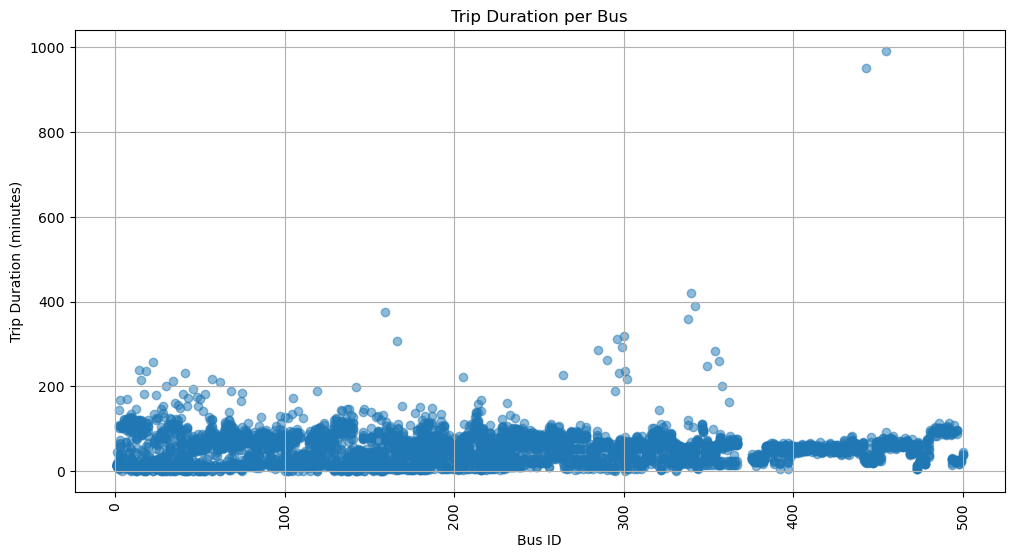

In [11]:
df_timetable['trip_duration_minutes'] = (df_timetable['triplog_end_time'] - df_timetable['triplog_begin_time']).dt.total_seconds() / 60
df_timetable['trip_duration'] = (df_timetable['triplog_end_time'] - df_timetable['triplog_begin_time']).dt.total_seconds()
plt.figure(figsize=(12, 6))
plt.scatter(df_timetable['busid'], df_timetable['trip_duration_minutes'], alpha=0.5)
plt.xlabel('Bus ID')
plt.ylabel('Trip Duration (minutes)')
plt.title('Trip Duration per Bus')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [12]:
# Average travel duration for each bus
df_timetable['run_duration_minutes'] = (df_timetable['triplog_end_time'] - df_timetable['triplog_begin_time']).dt.total_seconds() / 60
average_duration_per_bus = df_timetable.groupby('busid')['run_duration_minutes'].mean()
average_duration_bus = df_timetable['run_duration_minutes'].mean()
print(f"Average travel duration for buses: ", average_duration_bus.round(2), " minutes")
print(average_duration_per_bus)

Average travel duration for buses:  51.37  minutes
busid
1      15.690152
2      54.729167
3      59.331818
4      53.524242
5      61.534848
         ...    
496    23.871667
497    94.429167
498    16.541667
499    25.162500
500    40.612500
Name: run_duration_minutes, Length: 470, dtype: float64


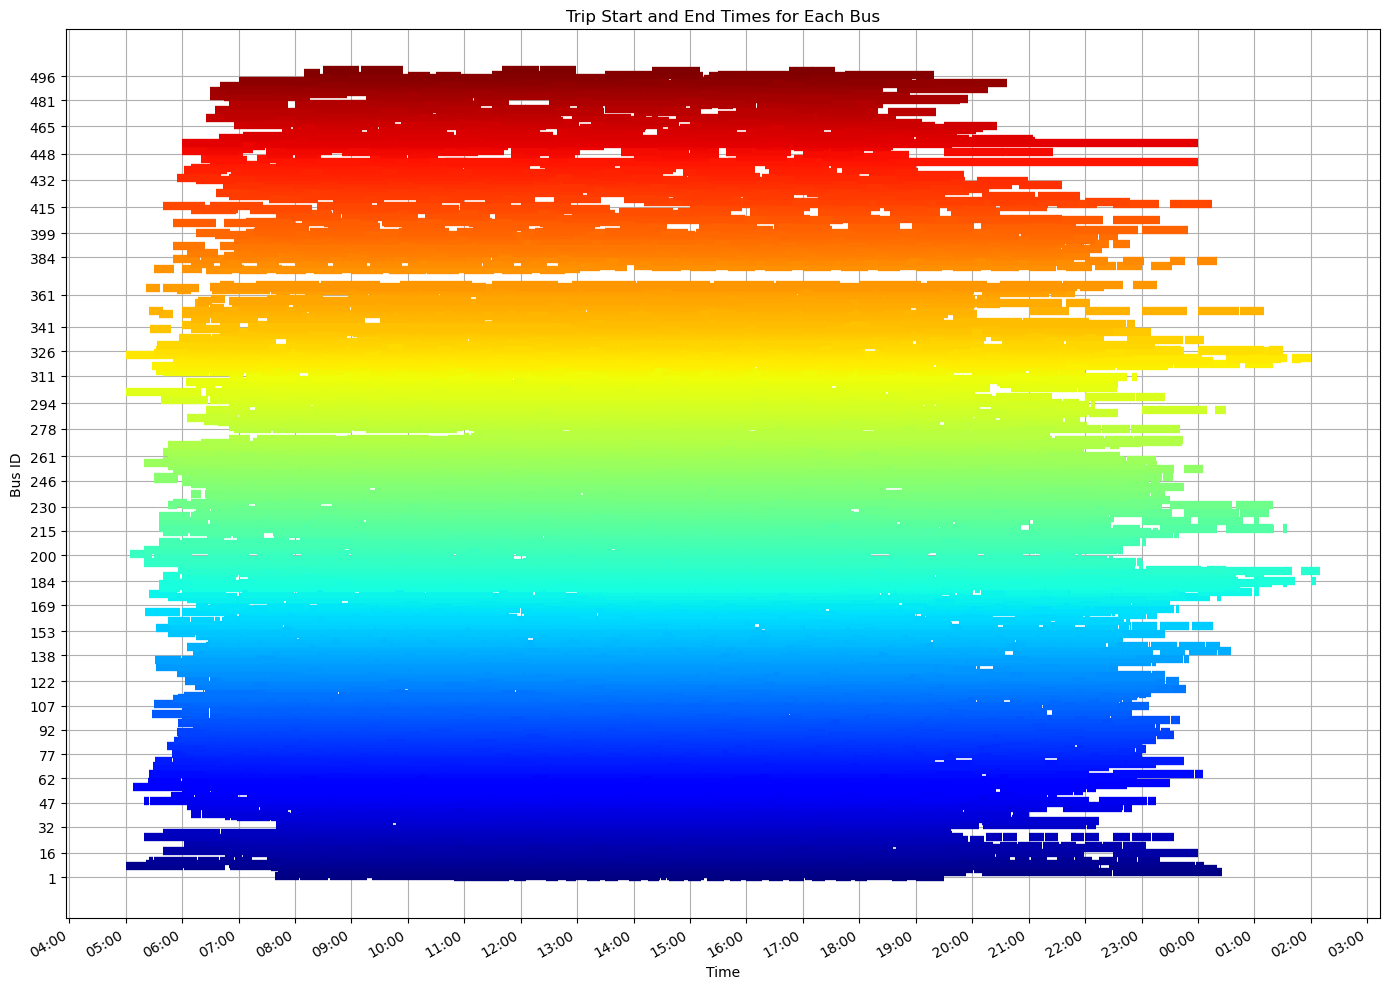

In [13]:
df_timetable.sort_values(by=['busid', 'triplog_begin_time'], inplace=True)

plt.figure(figsize=(14,10))
bus_ids = df_timetable['busid'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(bus_ids)))
color_dict = dict(zip(bus_ids, colors))

for i, row in df_timetable.iterrows():
    start = mdates.date2num(row['triplog_begin_time'])
    end = mdates.date2num(row['triplog_end_time'])
    plt.hlines(y=row['busid'], xmin=start, xmax=end, colors=color_dict[row['busid']], linewidth=6)

plt.xlabel('Time')
plt.ylabel('Bus ID')
plt.title('Trip Start and End Times for Each Bus')
plt.yticks(bus_ids)  # Ensure only bus IDs are used as y-ticks
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Every hour
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Only hours and minutes
plt.gcf().autofmt_xdate()  # Rotation

if len(bus_ids) > 30:
    plt.gca().set_yticks(plt.gca().get_yticks()[::int(len(bus_ids)/30)])

handles = [plt.Line2D([0], [0], color=color, linewidth=6) for color in colors]
plt.tight_layout()
plt.grid(True)
plt.show()

In [14]:
df_timetable.columns

Index(['busid', 'triplog_id', 'change_info', 'depart_interval', 'direction',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'route_id_run', 'route_name_run', 'route_sub_id',
       'route_sub_name', 'run_date', 'run_duration', 'run_mileage',
       'running_no', 'service_type', 'triplog_begin_time', 'triplog_end_time',
       'service_name', 'trip_duration_minutes', 'trip_duration',
       'run_duration_minutes'],
      dtype='object')

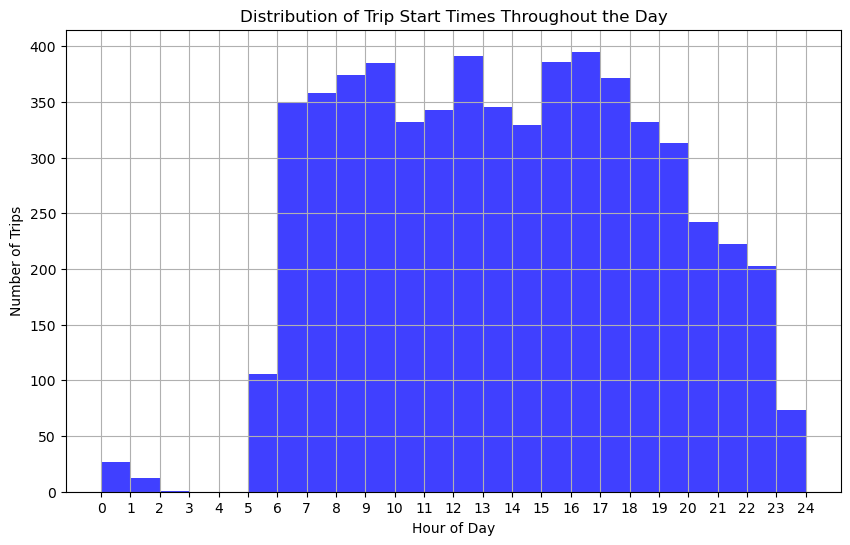

In [15]:
plt.figure(figsize=(10, 6))
df_timetable['hour_of_day'] = df_timetable['triplog_begin_time'].dt.hour
df_timetable['hour_of_day'].hist(bins=24, range=(0,24), alpha=0.75, color='blue')
plt.title('Distribution of Trip Start Times Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 25, 1))  # Hour marks
plt.grid(True)
plt.show()

Total number of unique routes: 141
Total number of trips recorded: 5889


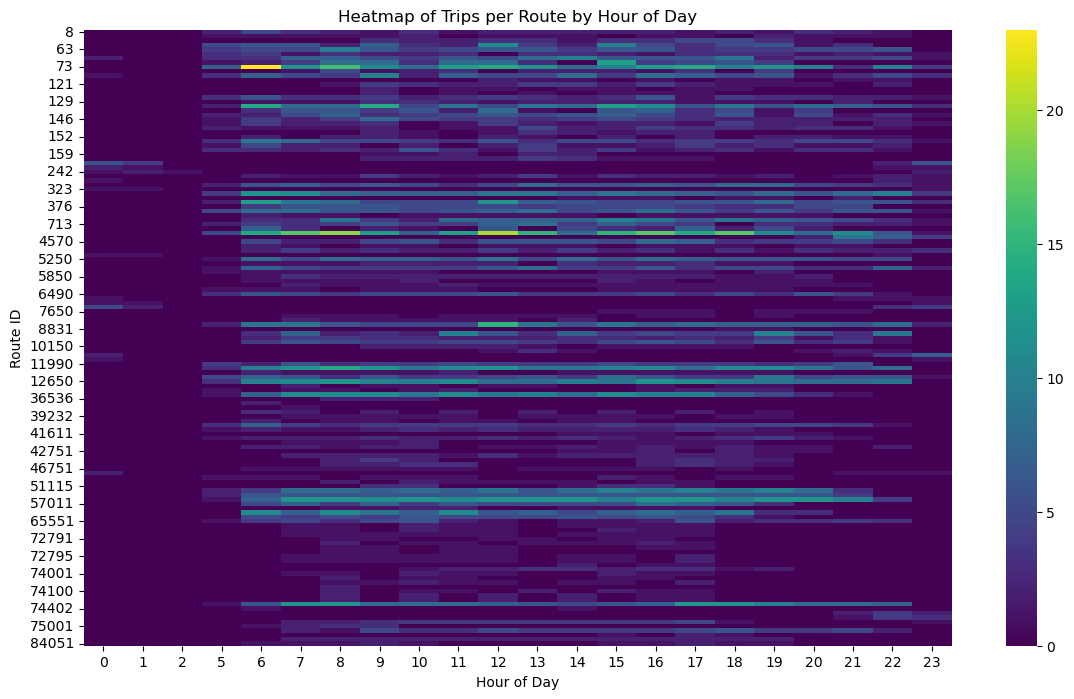

In [16]:
#Which routes are most utilized?
pivot_table = df_timetable.pivot_table(index='route_id_run', columns=df_timetable['triplog_begin_time'].dt.hour, 
                                       values='triplog_id', aggfunc='count', fill_value=0)
# Number of unique routes
unique_routes = df_timetable['route_id_run'].nunique()
print(f"Total number of unique routes: {unique_routes}")

# Number of trips
print(f"Total number of trips recorded: {len(df_timetable)}")
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=False, fmt='d', cmap='viridis')
plt.title('Heatmap of Trips per Route by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Route ID')
plt.show()

# Trips BEB

In [17]:
df_can = pd.read_csv(file_path_can, sep='\t', encoding='utf-8')
df_can['local_time'] = pd.to_datetime(df_can['local_time'], format='%Y%m%d %H%M%S', errors='coerce')
# df_can.dropna(inplace=True)
df_can['busid'] = df_can['busid'].astype(str)
df_can.drop_duplicates(inplace=True)
df_can.head()

,busid,rightctrl_temp,rightmotor_windingtemp,leftmotor_windingtemp,total_current,gears,total_mileage,brakepedal_status,handbrake_status,soc,...,headlight,right_trunlight,redis_time,ac_switch,speaker_status,outside_car_temperature,inside_car_temperature,ac_workmode,ac_set_temperature,acceleration_pedal
0,51,0,0,0,510,01,27836,0,0,40,...,0,0,20210501 181248,1.0,0.0,33,0,40.0,25,0
1,432,0,0,0,0,83,0,0,0,0,...,0,0,20210501 181248,0.0,0.0,0,0,0.0,0,0
2,119,34,0,40,2,7d,15312,0,1,70,...,0,0,20210501 181248,1.0,0.0,29,26,1.0,25,0
3,100,41,0,43,8,7e,15089,1,0,67,...,0,0,20210501 181248,0.0,0.0,31,26,0.0,25,0
4,494,40,0,42,0,7d,125881,1,1,72,...,0,0,20210501 181248,1.0,0.0,38,27,1.0,22,0


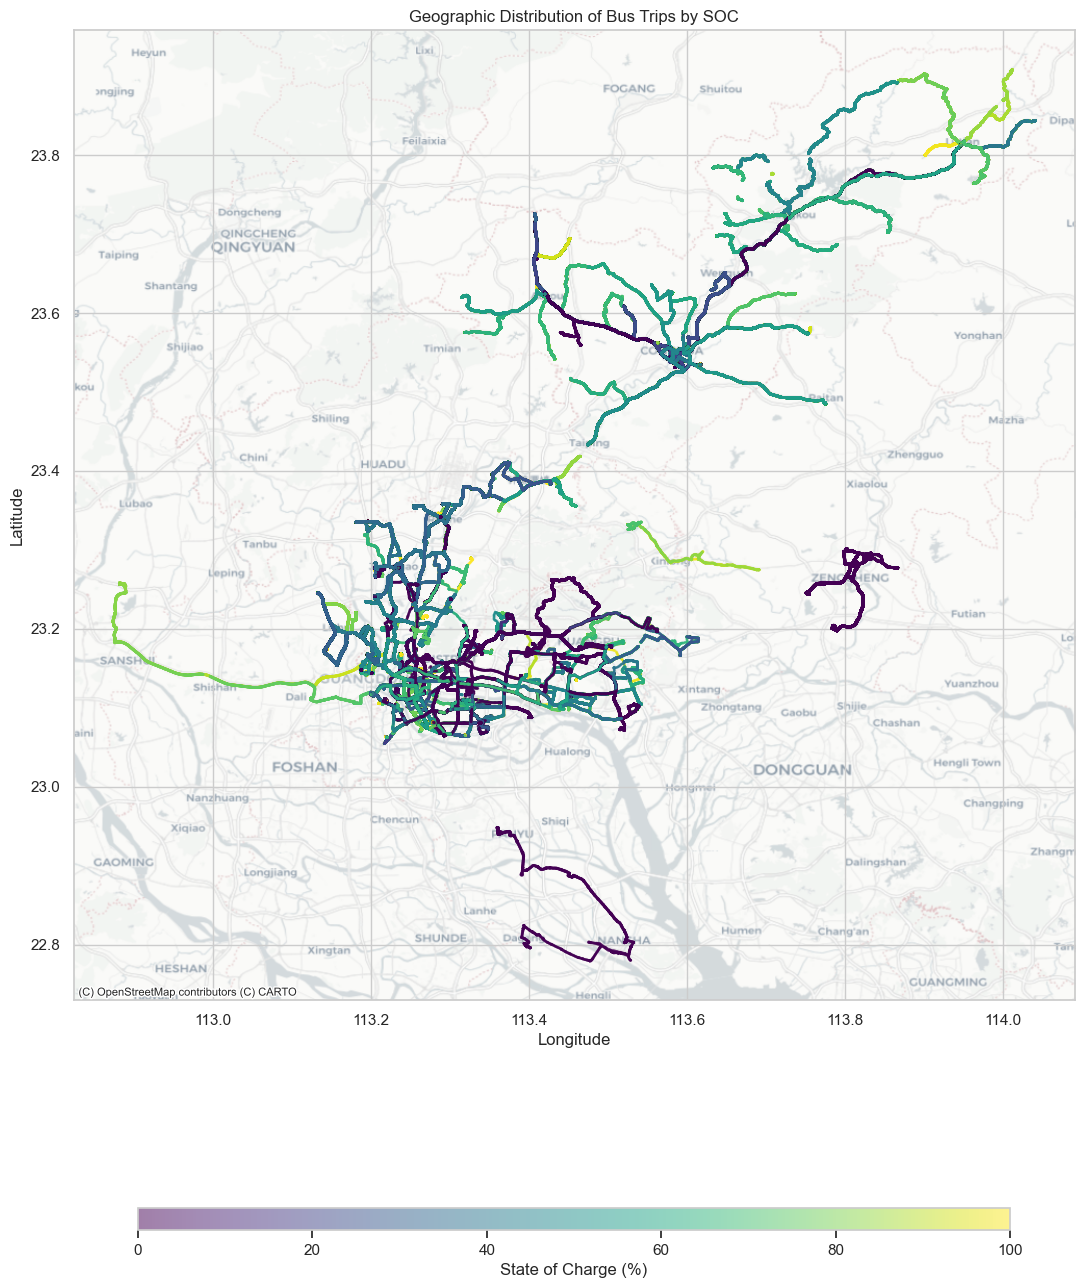

In [50]:
# Check for geometric outliers for distance calculations
df_can = df_can[(df_can.latitude != 0) & (df_can.longitude != 0)]
df_can = df_can.dropna(subset=['latitude', 'longitude'])

gdf = gpd.GeoDataFrame(
    df_can,
    geometry=gpd.points_from_xy(df_can.longitude, df_can.latitude),
    crs="EPSG:4326"  # WGS GPS
)

fig, ax = plt.subplots(figsize=(15, 16))
scatter = gdf.plot(ax=ax, markersize=1, alpha=0.5, column='soc', cmap='viridis', legend=False)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_xlim([df_can.longitude.min() - 0.05, df_can.longitude.max() + 0.05])
ax.set_ylim([df_can.latitude.min() - 0.05, df_can.latitude.max() + 0.05])
if hasattr(scatter, 'collections'):
    cbar = fig.colorbar(scatter.collections[0], ax=ax, orientation='horizontal', shrink=0.75, aspect=40)
    cbar.set_label('State of Charge (%)')
ax.set_title('Geographic Distribution of Bus Trips by SOC')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.savefig("soc_levels.png", dpi=300)
plt.show()

In [19]:
print(df_can['busid'].nunique(), "unique bus IDs in df_can")
print(df_timetable['busid'].nunique(), "unique bus IDs in df_timetable")
# print(df_can['route_id_run'].nunique(), "unique routes in df_can")
print(df_timetable['route_id_run'].nunique(), "unique routes in df_timetable")

460 unique bus IDs in df_can
470 unique bus IDs in df_timetable
141 unique routes in df_timetable


In [20]:
print(df_can.isnull().sum(), "missing values in df_can")

busid                             0
rightctrl_temp                    0
rightmotor_windingtemp            0
leftmotor_windingtemp             0
total_current                     0
gears                             0
total_mileage                     0
brakepedal_status                 0
handbrake_status                  0
soc                               0
direction                         0
leftmotor_workingmode        141325
reversing_light                   0
stoplight                         0
speed                             0
longitude                         0
charge_status                     0
door1_status                      0
dipped_headlight                  0
ns_direction                      0
rightctrl_radiatortemp            0
total_voltage                     0
door2_status                      0
latitude                          0
leftmotor_rpm               4835126
leftctrl_temp                     0
leftctrl_radiatortemp             0
rightmotor_rpm             1

In [21]:
columns_with_nans = ['leftmotor_workingmode', 'leftmotor_rpm', 'rightmotor_rpm', 
                              'rightmotor_workingmode', 'ac_switch', 'speaker_status', 'ac_workmode']

for column in columns_with_nans:
    if df_can[column].isnull().sum() > len(df_can) * 0.5:  #Over 50% missing
        df_can.drop(column, axis=1, inplace=True)
df_can.columns

Index(['busid', 'rightctrl_temp', 'rightmotor_windingtemp',
       'leftmotor_windingtemp', 'total_current', 'gears', 'total_mileage',
       'brakepedal_status', 'handbrake_status', 'soc', 'direction',
       'leftmotor_workingmode', 'reversing_light', 'stoplight', 'speed',
       'longitude', 'charge_status', 'door1_status', 'dipped_headlight',
       'ns_direction', 'rightctrl_radiatortemp', 'total_voltage',
       'door2_status', 'latitude', 'leftmotor_rpm', 'leftctrl_temp',
       'leftctrl_radiatortemp', 'left_trunlight', 'front_foglamp',
       'speed_onwheel', 'ew_direction', 'local_time', 'rightmotor_workingmode',
       'headlight', 'right_trunlight', 'redis_time', 'ac_switch',
       'speaker_status', 'outside_car_temperature', 'inside_car_temperature',
       'ac_workmode', 'ac_set_temperature', 'acceleration_pedal'],
      dtype='object')

# Merge datasets and relevant attributes- timtable and trip details

In [22]:
# Ensure both dataframes have 'busid' as string type for consistent merging
df_can['busid'] = df_can['busid'].astype(str)
df_timetable['busid'] = df_timetable['busid'].astype(str)

# Convert 'local_time' in df_can to datetime if not already
df_can['local_time'] = pd.to_datetime(df_can['local_time'])

# Ensure the timetable times are in datetime format
df_timetable['triplog_begin_time'] = pd.to_datetime(df_timetable['triplog_begin_time'])
df_timetable['triplog_end_time'] = pd.to_datetime(df_timetable['triplog_end_time'])

# Sort dataframes by the key you will merge on
df_can.sort_values('local_time', inplace=True)
df_timetable.sort_values('triplog_begin_time', inplace=True)

# Perform an asof merge to find the closest prior match without going after 'local_time'
merged_data = pd.merge_asof(df_can, df_timetable, by='busid', left_on='local_time', right_on='triplog_begin_time',
                            direction='backward', tolerance=pd.Timedelta('1 hour'))

# Now filter out records where local_time is greater than triplog_end_time to ensure they fall within the trip duration
merged_data = merged_data[merged_data['local_time'] <= merged_data['triplog_end_time']]
merged_data.head()

,busid,rightctrl_temp,rightmotor_windingtemp,leftmotor_windingtemp,total_current,gears,total_mileage,brakepedal_status,handbrake_status,soc,...,run_mileage,running_no,service_type,triplog_begin_time,triplog_end_time,service_name,trip_duration_minutes,trip_duration,run_duration_minutes,hour_of_day
2243804,301,30,0,35,0,7d,18010,0,1,100,...,16.43,1.0,-8.0,2021-05-01 05:00:00,2021-05-01 06:20:00,Prominence,80.0,4800.0,80.0,5.0
2243892,324,0,0,0,0,00,0,0,0,0,...,37.00,1.0,-8.0,2021-05-01 05:00:00,2021-05-01 06:00:00,Prominence,60.0,3600.0,60.0,5.0
2244835,324,0,0,0,0,00,0,0,0,0,...,37.00,1.0,-8.0,2021-05-01 05:00:00,2021-05-01 06:00:00,Prominence,60.0,3600.0,60.0,5.0
2244873,301,30,0,35,0,7d,18010,0,1,100,...,16.43,1.0,-8.0,2021-05-01 05:00:00,2021-05-01 06:20:00,Prominence,80.0,4800.0,80.0,5.0
2245837,324,0,0,0,0,00,0,0,0,0,...,37.00,1.0,-8.0,2021-05-01 05:00:00,2021-05-01 06:00:00,Prominence,60.0,3600.0,60.0,5.0


In [23]:
merged_data.columns

Index(['busid', 'rightctrl_temp', 'rightmotor_windingtemp',
       'leftmotor_windingtemp', 'total_current', 'gears', 'total_mileage',
       'brakepedal_status', 'handbrake_status', 'soc', 'direction_x',
       'leftmotor_workingmode', 'reversing_light', 'stoplight', 'speed',
       'longitude', 'charge_status', 'door1_status', 'dipped_headlight',
       'ns_direction', 'rightctrl_radiatortemp', 'total_voltage',
       'door2_status', 'latitude', 'leftmotor_rpm', 'leftctrl_temp',
       'leftctrl_radiatortemp', 'left_trunlight', 'front_foglamp',
       'speed_onwheel', 'ew_direction', 'local_time', 'rightmotor_workingmode',
       'headlight', 'right_trunlight', 'redis_time', 'ac_switch',
       'speaker_status', 'outside_car_temperature', 'inside_car_temperature',
       'ac_workmode', 'ac_set_temperature', 'acceleration_pedal', 'triplog_id',
       'change_info', 'depart_interval', 'direction_y', 'from_station_id',
       'from_station_name', 'to_station_id', 'to_station_name', 'rou

In [24]:
merged_data['shifted_latitude'] = merged_data.groupby(['busid', 'triplog_id'])['latitude'].shift(-1)
merged_data['shifted_longitude'] = merged_data.groupby(['busid', 'triplog_id'])['longitude'].shift(-1)
merged_data['segment_distance'] = merged_data.apply(
    lambda row: calculate_distance(row['latitude'], row['longitude'], row['shifted_latitude'], row['shifted_longitude'])
    if pd.notnull(row['shifted_latitude']) else 0, axis=1)

# Summarize distances by busid, route, and trip
df_travelled = merged_data.groupby(['trip_duration', 'run_duration_minutes','busid', 'route_id_run', 'triplog_id'])['segment_distance'].sum().reset_index()
df_travelled.rename(columns={'segment_distance': 'total_distance_km'}, inplace=True)

# Summarize charging times by busid, route, and trip
merged_data['charging'] = merged_data['charge_status'] == 1
merged_data['next_time'] = merged_data.groupby(['busid', 'triplog_id'])['local_time'].shift(-1)
merged_data['charging_time_sec'] = merged_data.apply(
    lambda row: (row['next_time'] - row['local_time']).total_seconds() if row['charging'] else 0, axis=1)
df_charging = merged_data.groupby(['busid', 'route_id_run', 'triplog_id'])['charging_time_sec'].sum().reset_index()
df_charging.rename(columns={'charging_time_sec': 'total_charging_time_sec'}, inplace=True)

# Merging distance and charging time dataframes on 'busid', 'route_id_run', and 'triplog_id'
final_data = pd.merge(df_travelled, df_charging, on=['busid', 'route_id_run', 'triplog_id'], how='outer')
final_data.fillna(0, inplace=True)  # no charging time or distance is recorded as 0
final_data['speed'] = final_data['total_distance_km'] / final_data['run_duration_minutes']
final_data.head()

,trip_duration,run_duration_minutes,busid,route_id_run,triplog_id,total_distance_km,total_charging_time_sec,speed
0,832.0,13.866667,10,71.0,914788054.0,3.321259,0.0,0.239514
1,6792.0,113.200000,10,71.0,914790455.0,15.136378,0.0,0.133714
2,7392.0,123.200000,10,71.0,914837567.0,11.528872,0.0,0.093579
3,600.0,10.000000,10,71.0,914887390.0,2.271412,0.0,0.227141
4,600.0,10.000000,10,71.0,914890423.0,0.090171,0.0,0.009017


In [25]:
print('segment_distance', merged_data['segment_distance'].min())
print('Min total_distance_km', final_data['total_distance_km'].min())
print('Max total_distance_km', final_data['total_distance_km'].max())
final_data[final_data['total_charging_time_sec'] == final_data['total_charging_time_sec'].max()]

segment_distance 0.0
Min total_distance_km 0.0
Max total_distance_km 60.880683236627775


,trip_duration,run_duration_minutes,busid,route_id_run,triplog_id,total_distance_km,total_charging_time_sec,speed
2060,9600.0,160.0,231,131.0,914934293.0,0.0,3551.0,0.0


In [26]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   trip_duration            5478 non-null   float64
 1   run_duration_minutes     5478 non-null   float64
 2   busid                    5478 non-null   object 
 3   route_id_run             5478 non-null   float64
 4   triplog_id               5478 non-null   float64
 5   total_distance_km        5478 non-null   float64
 6   total_charging_time_sec  5478 non-null   float64
 7   speed                    5478 non-null   float64
dtypes: float64(7), object(1)
memory usage: 342.5+ KB


In [27]:
print(f'Unique Routes: ', final_data['route_id_run'].nunique(), '; Unique Trips: ', final_data['triplog_id'].nunique())

Unique Routes:  134 ; Unique Trips:  5478


In [28]:
final_data.to_csv('Dist_charging.csv', index=False)

In [29]:
merged_df=merged_data
datetime_columns = ['local_time', 'redis_time', 'triplog_begin_time', 'triplog_end_time']
for col in datetime_columns: merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')

#Calculate Energy Concumption for direction
merged_df.sort_values(by=['busid', 'local_time'], inplace=True)
merged_df['ec'] = merged_df.groupby('busid')['soc'].transform(lambda x: x.diff())
if 'direction_x' in merged_df.columns: merged_df['ec'] = merged_df.apply(lambda row: -row['ec'] if row['direction_x'] < 0 else row['ec'], axis=1)
merged_df['ec'] = merged_df['ec'].fillna(0)

merged_df['leftmotor_rpm'] = pd.to_numeric(merged_df['leftmotor_rpm'], errors='coerce')
merged_df['duration'] = merged_df.groupby('busid')['local_time'].diff().dt.total_seconds().div(60).fillna(0)
merged_df.head()

,busid,rightctrl_temp,rightmotor_windingtemp,leftmotor_windingtemp,total_current,gears,total_mileage,brakepedal_status,handbrake_status,soc,...,run_duration_minutes,hour_of_day,shifted_latitude,shifted_longitude,segment_distance,charging,next_time,charging_time_sec,ec,duration
4131614,10,-226,249,249,-30,7e,149934,1,0,100,...,13.866667,8.0,23.168333,113.238056,0.0,False,2021-05-01 08:00:09,0.0,0.0,0.000000
4131826,10,-226,249,249,-21,7e,149934,1,0,100,...,13.866667,8.0,23.168333,113.238056,0.0,False,2021-05-01 08:00:10,0.0,0.0,0.016667
4132120,10,-226,249,249,-24,7e,149934,1,0,100,...,13.866667,8.0,23.168333,113.238056,0.0,False,2021-05-01 08:00:11,0.0,0.0,0.016667
4132457,10,-226,249,249,-11,7e,149934,1,0,100,...,13.866667,8.0,23.168333,113.238056,0.0,False,2021-05-01 08:00:12,0.0,0.0,0.016667
4132783,10,-225,249,249,0,7e,149934,1,0,100,...,13.866667,8.0,23.168333,113.238056,0.0,False,2021-05-01 08:00:13,0.0,0.0,0.016667


In [30]:
merged_df.columns

Index(['busid', 'rightctrl_temp', 'rightmotor_windingtemp',
       'leftmotor_windingtemp', 'total_current', 'gears', 'total_mileage',
       'brakepedal_status', 'handbrake_status', 'soc', 'direction_x',
       'leftmotor_workingmode', 'reversing_light', 'stoplight', 'speed',
       'longitude', 'charge_status', 'door1_status', 'dipped_headlight',
       'ns_direction', 'rightctrl_radiatortemp', 'total_voltage',
       'door2_status', 'latitude', 'leftmotor_rpm', 'leftctrl_temp',
       'leftctrl_radiatortemp', 'left_trunlight', 'front_foglamp',
       'speed_onwheel', 'ew_direction', 'local_time', 'rightmotor_workingmode',
       'headlight', 'right_trunlight', 'redis_time', 'ac_switch',
       'speaker_status', 'outside_car_temperature', 'inside_car_temperature',
       'ac_workmode', 'ac_set_temperature', 'acceleration_pedal', 'triplog_id',
       'change_info', 'depart_interval', 'direction_y', 'from_station_id',
       'from_station_name', 'to_station_id', 'to_station_name', 'rou

In [31]:
print(merged_df['ec'].max(), merged_df['ec'].min())
merged_df['ec'].describe()

100.0 -100.0


count    8.475252e+06
mean    -1.818825e-03
std      5.747653e-01
min     -1.000000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+02
Name: ec, dtype: float64

In [32]:
extreme_charges = merged_df[(merged_df['ec'] == 100) | (merged_df['ec'] == -100)]
extreme_charges[['from_station_name','to_station_name','busid','segment_distance','local_time', 'direction_x', 'soc', 'ec', 'trip_duration']]

,from_station_name,to_station_name,busid,segment_distance,local_time,direction_x,soc,ec,trip_duration
4314731,Yajun Mingde Charging Station,Sai Wan Road (Downing Gardens) Terminal,10,0.0,2021-05-01 08:12:04,59,0,-100.0,832.0
4314952,Yajun Mingde Charging Station,Sai Wan Road (Downing Gardens) Terminal,10,0.0,2021-05-01 08:12:05,59,100,100.0,832.0
2425959,Dream Car Town Charging Station,Jinshazhou (Taole Street) Terminal,108,0.0,2021-05-01 05:30:35,0,100,100.0,2643.0
3160985,China Overseas Sands Bay Charging Station,Jinshazhou (Taole Street) Terminal,110,0.0,2021-05-01 06:48:50,357,0,-100.0,2413.0
3161304,China Overseas Sands Bay Charging Station,Jinshazhou (Taole Street) Terminal,110,0.0,2021-05-01 06:48:51,357,100,100.0,2413.0
2568319,Dream Car Town Charging Station,Jinshazhou (Taole Street) Terminal,111,0.0,2021-05-01 05:50:49,0,100,100.0,2324.0
2655977,Dream Car Town Charging Station,Jinshazhou (Taole Street) Terminal,113,0.0,2021-05-01 06:01:45,358,100,100.0,2007.0
2773639,Xiamao Passenger Transport Station Charging St...,Huiqiao South Road Terminal,119,0.0,2021-05-01 06:14:35,0,100,100.0,1800.0
2865704,Xingguo (Jianggao) Charging Station,Jiaoxin Subway Station,120,0.0,2021-05-01 06:23:30,0,100,100.0,4595.0
3695000,Jianggao (Guangdong Technical College Baiyun C...,Nanling Village Terminal,125,0.0,2021-05-01 07:29:43,250,0,-100.0,3723.0


In [33]:
def mode_or_single_value(x):
    if len(x.unique()) == 1:
        return x.iloc[0]
    else:
        mode_result = x.mode()
        if not mode_result.empty:
            return mode_result.iloc[0]
        else:
            return None  # Handle empty result

# Revised aggregation functions for different columns
aggregation_functions = {
    'rightctrl_temp': 'median',
    'rightmotor_windingtemp': 'median',
    'leftmotor_windingtemp': 'median',
    'total_current': 'max',
    'gears': mode_or_single_value,
    'total_mileage': 'max',
    'brakepedal_status': lambda x: (x != 0).sum(),
    'handbrake_status': lambda x: (x != 0).sum(),
    'soc': 'min',
    'direction_x': 'mean',
    'leftmotor_workingmode': mode_or_single_value,
    'reversing_light': lambda x: (x != 0).sum(),
    'stoplight': lambda x: (x != 0).sum(),
    'speed': 'mean',
    'charge_status': 'max',
    'door1_status': lambda x: (x != 0).sum(),
    'dipped_headlight': lambda x: (x != 0).sum(),
    'ns_direction': mode_or_single_value,
    'rightctrl_radiatortemp': 'mean',
    'total_voltage': 'mean',
    'door2_status': lambda x: (x != 0).sum(),
    'leftmotor_rpm': 'median',
    'leftctrl_temp': 'mean',
    'leftctrl_radiatortemp': 'mean',
    'left_trunlight': lambda x: (x != 0).sum(),
    'front_foglamp': lambda x: (x != 0).sum(),
    'speed_onwheel': 'median',
    'ew_direction': mode_or_single_value,
    'local_time': 'last',
    'rightmotor_workingmode': mode_or_single_value,
    'headlight': lambda x: (x != 0).sum(),
    'right_trunlight': lambda x: (x != 0).sum(),
    'redis_time': 'last',
    'ac_switch': lambda x: (x != 0).sum(),
    'speaker_status': lambda x: (x != 0).sum(),
    'outside_car_temperature': 'max',
    'inside_car_temperature': 'mean',
    'ac_workmode': lambda x: (x != 0).sum(),
    'ac_set_temperature': 'mean',
    'acceleration_pedal': lambda x: (x != 0).sum(),
    'change_info': 'last',
    'depart_interval': 'median',
    'from_station_id': 'first',
    'from_station_name': 'first',
    'to_station_id': 'last',
    'to_station_name': 'last',
    'route_name_run': 'last',
    'route_sub_id': 'last',
    'route_sub_name': 'last',
    'run_date': 'last',
    'run_duration': 'sum',
    'run_mileage': 'sum',
    'running_no': 'last',
    'service_type': 'last',
    'triplog_begin_time': 'first',
    'triplog_end_time': 'last',
    'service_name': 'last',
    'ec': 'sum',
    'duration': 'sum'
}

In [34]:
final_data1 = merged_df.groupby(['busid', 'route_id_run', 'triplog_id']).agg(aggregation_functions).reset_index()

time_intervals = [(0, 6), (6, 12), (12, 18), (18, 24)]
time_labels = ['Early_Morning', 'Morning', 'Afternoon', 'Evening']

final_data1['time_cat'] = pd.cut(final_data1['triplog_begin_time'].dt.hour,
                                bins=[0, 6, 12, 18, 24],
                                labels=time_labels,
                                right=False)

final_data1['triplog_begin_time'] = final_data1['triplog_begin_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
final_data1['triplog_end_time'] = final_data1['triplog_end_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
final_data1.head()

,busid,route_id_run,triplog_id,rightctrl_temp,rightmotor_windingtemp,leftmotor_windingtemp,total_current,gears,total_mileage,brakepedal_status,...,run_duration,run_mileage,running_no,service_type,triplog_begin_time,triplog_end_time,service_name,ec,duration,time_cat
0,10,71.0,914788054.0,33.0,35.0,36.0,177,7e,149936,73,...,10595.0,652.0,1.0,-8.0,2021-05-01 08:00:08,2021-05-01 08:14:00,Prominence,0.0,13.866667,Morning
1,10,71.0,914790455.0,39.0,41.0,43.0,231,7e,149950,766,...,405331.0,82859.7,2.0,1.0,2021-05-01 08:15:00,2021-05-01 10:08:12,Full journey,-5.0,61.000000,Morning
2,10,71.0,914837567.0,43.0,45.0,46.0,234,7e,149969,698,...,439971.0,80482.5,3.0,1.0,2021-05-01 10:11:00,2021-05-01 12:14:12,Full journey,-8.0,116.000000,Morning
3,10,71.0,914887390.0,47.0,49.0,68.0,206,7e,149984,68,...,4010.0,240.6,4.0,-9.0,2021-05-01 12:16:00,2021-05-01 12:26:00,Admission,-6.0,71.716667,Afternoon
4,10,71.0,914890423.0,44.0,43.0,43.0,89,7d,149987,52,...,5970.0,417.9,6.0,-98.0,2021-05-01 14:36:00,2021-05-01 14:46:00,Position,-1.0,143.283333,Afternoon


In [35]:
final_data2 = merged_df.groupby(['busid', 'route_id_run', 'triplog_id']).agg({
    'longitude': ['first', 'last'],
    'latitude': ['first', 'last']
}).reset_index()

final_data2.columns = ['_'.join(col).strip() if col[1] else col[0] for col in final_data2.columns]
final_data2 = final_data2.rename(columns={
    'longitude_first': 'longitude_origin',
    'longitude_last': 'longitude_destination',
    'latitude_first': 'latitude_origin',
    'latitude_last': 'latitude_destination'
})
final_data2.head()

,busid,route_id_run,triplog_id,longitude_origin,longitude_destination,latitude_origin,latitude_destination
0,10,71.0,914788054.0,113.238056,113.236667,23.168333,23.154722
1,10,71.0,914790455.0,113.236667,113.241944,23.154444,23.131111
2,10,71.0,914837567.0,113.271111,113.243333,23.074167,23.135556
3,10,71.0,914887390.0,113.235833,113.238056,23.154444,23.167500
4,10,71.0,914890423.0,113.236944,113.236667,23.154444,23.155000


In [36]:
merged_final_data = pd.merge(final_data, final_data1, on=['busid', 'route_id_run', 'triplog_id'], how='inner', suffixes=('', '_drop'))
merged_final_data = pd.merge(merged_final_data, final_data2, on=['busid', 'route_id_run', 'triplog_id'], how='inner', suffixes=('', '_drop'))
merged_final_data = merged_final_data.loc[:, ~merged_final_data.columns.str.endswith('_drop')]
merged_final_data.rename(columns={'direction_x': 'direction_deg'}, inplace=True)
merged_final_data.head()

,trip_duration,run_duration_minutes,busid,route_id_run,triplog_id,total_distance_km,total_charging_time_sec,speed,rightctrl_temp,rightmotor_windingtemp,...,triplog_begin_time,triplog_end_time,service_name,ec,duration,time_cat,longitude_origin,longitude_destination,latitude_origin,latitude_destination
0,832.0,13.866667,10,71.0,914788054.0,3.321259,0.0,0.239514,33.0,35.0,...,2021-05-01 08:00:08,2021-05-01 08:14:00,Prominence,0.0,13.866667,Morning,113.238056,113.236667,23.168333,23.154722
1,6792.0,113.200000,10,71.0,914790455.0,15.136378,0.0,0.133714,39.0,41.0,...,2021-05-01 08:15:00,2021-05-01 10:08:12,Full journey,-5.0,61.000000,Morning,113.236667,113.241944,23.154444,23.131111
2,7392.0,123.200000,10,71.0,914837567.0,11.528872,0.0,0.093579,43.0,45.0,...,2021-05-01 10:11:00,2021-05-01 12:14:12,Full journey,-8.0,116.000000,Morning,113.271111,113.243333,23.074167,23.135556
3,600.0,10.000000,10,71.0,914887390.0,2.271412,0.0,0.227141,47.0,49.0,...,2021-05-01 12:16:00,2021-05-01 12:26:00,Admission,-6.0,71.716667,Afternoon,113.235833,113.238056,23.154444,23.167500
4,600.0,10.000000,10,71.0,914890423.0,0.090171,0.0,0.009017,44.0,43.0,...,2021-05-01 14:36:00,2021-05-01 14:46:00,Position,-1.0,143.283333,Afternoon,113.236944,113.236667,23.154444,23.155000


In [37]:
# Filter out trips with nil travel distance
print('Min total_distance_km before:', merged_final_data['total_distance_km'].min())
merged_final_data = merged_final_data[merged_final_data['total_distance_km'] > 0.1]
print('Min total_distance_km after:', merged_final_data['total_distance_km'].min())

Min total_distance_km before: 0.0
Min total_distance_km after: 0.1037250781286107


In [38]:
merged_final_data['total_distance_km'].describe()

count    5151.000000
mean       15.234825
std         9.461848
min         0.103725
25%         8.042994
50%        13.904044
75%        21.262606
max        60.880683
Name: total_distance_km, dtype: float64

In [39]:
merged_final_data.columns

Index(['trip_duration', 'run_duration_minutes', 'busid', 'route_id_run',
       'triplog_id', 'total_distance_km', 'total_charging_time_sec', 'speed',
       'rightctrl_temp', 'rightmotor_windingtemp', 'leftmotor_windingtemp',
       'total_current', 'gears', 'total_mileage', 'brakepedal_status',
       'handbrake_status', 'soc', 'direction_deg', 'leftmotor_workingmode',
       'reversing_light', 'stoplight', 'charge_status', 'door1_status',
       'dipped_headlight', 'ns_direction', 'rightctrl_radiatortemp',
       'total_voltage', 'door2_status', 'leftmotor_rpm', 'leftctrl_temp',
       'leftctrl_radiatortemp', 'left_trunlight', 'front_foglamp',
       'speed_onwheel', 'ew_direction', 'local_time', 'rightmotor_workingmode',
       'headlight', 'right_trunlight', 'redis_time', 'ac_switch',
       'speaker_status', 'outside_car_temperature', 'inside_car_temperature',
       'ac_workmode', 'ac_set_temperature', 'acceleration_pedal',
       'change_info', 'depart_interval', 'from_station

In [40]:
categorical_columns = ['busid', 'triplog_id','time_cat', 'gears', 'ns_direction', 'ew_direction', 'charge_status',
                       'door1_status', 'door2_status', 'handbrake_status', 'brakepedal_status',
                       'headlight', 'dipped_headlight', 'left_trunlight', 'right_trunlight',
                       'front_foglamp', 'ac_switch', 'speaker_status', 'ac_workmode',
                       'service_name', 'from_station_name', 'to_station_name', 'route_name_run',
                       'route_sub_name', 'service_type']

for col in categorical_columns:
    if col in merged_final_data.columns:
        merged_final_data[col] = merged_final_data[col].astype('category')

merged_final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5151 entries, 0 to 5477
Data columns (total 71 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   trip_duration            5151 non-null   float64       
 1   run_duration_minutes     5151 non-null   float64       
 2   busid                    5151 non-null   category      
 3   route_id_run             5151 non-null   float64       
 4   triplog_id               5151 non-null   category      
 5   total_distance_km        5151 non-null   float64       
 6   total_charging_time_sec  5151 non-null   float64       
 7   speed                    5151 non-null   float64       
 8   rightctrl_temp           5151 non-null   float64       
 9   rightmotor_windingtemp   5151 non-null   float64       
 10  leftmotor_windingtemp    5151 non-null   float64       
 11  total_current            5151 non-null   int64         
 12  gears                    5151 non-null 

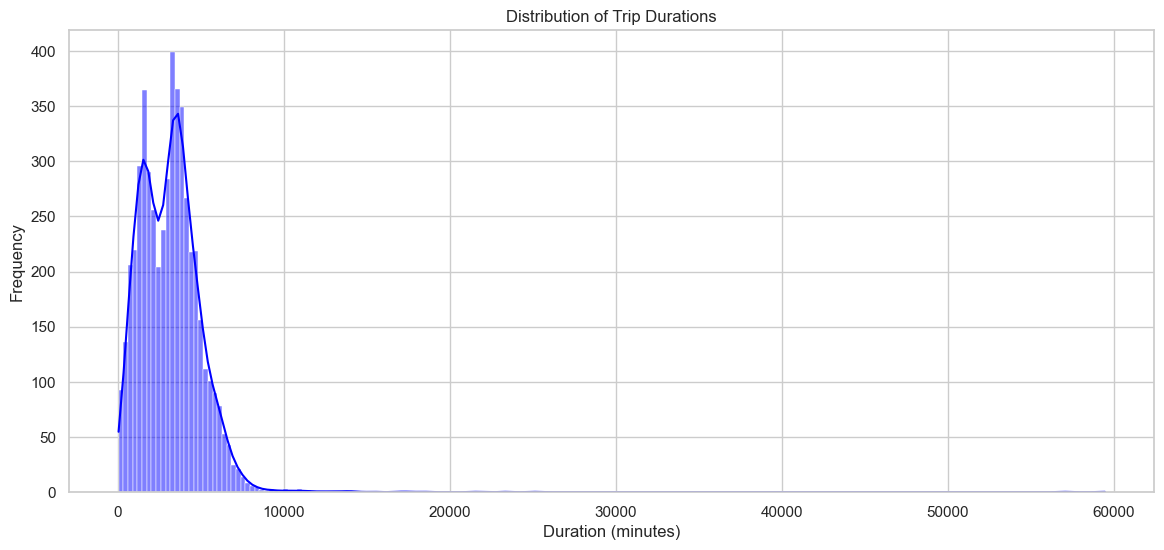

In [41]:
# Distribution of Trip Durations
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
sns.histplot(merged_final_data['trip_duration'], kde=True, color='blue')
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

Number of trips with zero distance: 0
Number of trips with non-zero charging time: 14


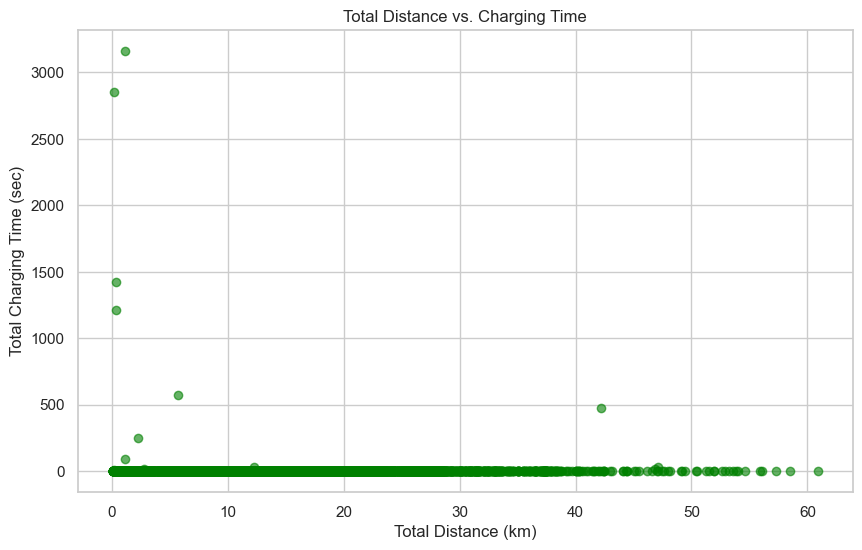

In [42]:
# Total Distance vs. Charging Time
num_trips_zero_distance = (merged_final_data['total_distance_km'] == 0).sum()
print(f'Number of trips with zero distance: {num_trips_zero_distance}')
num_trips_nonzero_charging = (merged_final_data['total_charging_time_sec'] > 0).sum()
print(f'Number of trips with non-zero charging time: {num_trips_nonzero_charging}')
plt.figure(figsize=(10, 6))
plt.scatter(merged_final_data['total_distance_km'], merged_final_data['total_charging_time_sec'], alpha=0.6, color='green')
plt.title('Total Distance vs. Charging Time')
plt.xlabel('Total Distance (km)')
plt.ylabel('Total Charging Time (sec)')
plt.grid(True)
plt.show()

In [43]:
non_zero_charging_trips = merged_final_data[merged_final_data['total_charging_time_sec'] > 0]
non_zero_charging_trips.head()

,trip_duration,run_duration_minutes,busid,route_id_run,triplog_id,total_distance_km,total_charging_time_sec,speed,rightctrl_temp,rightmotor_windingtemp,...,triplog_begin_time,triplog_end_time,service_name,ec,duration,time_cat,longitude_origin,longitude_destination,latitude_origin,latitude_destination
568,1424.0,23.733333,134,73.0,914747096.0,0.350610,1210.0,0.014773,38.0,0.0,...,2021-05-01 05:50:16,2021-05-01 06:14:00,Prominence,9.0,23.716667,Early_Morning,113.132778,113.133333,23.245000,23.245000
1099,6660.0,111.000000,167,253.0,914907279.0,0.177875,2851.0,0.001602,0.0,0.0,...,2021-05-01 13:09:00,2021-05-01 15:00:00,Double shift stop,23.0,62.000000,Afternoon,113.216111,113.216389,23.154722,23.155000
1249,180.0,3.000000,176,274.0,915111046.0,0.200087,10.0,0.066696,43.5,46.0,...,2021-05-01 22:17:00,2021-05-01 22:20:00,Admission,-1.0,3.500000,Evening,113.278611,113.278333,23.081111,23.081389
1333,6840.0,114.000000,182,43.0,915089862.0,1.111833,3160.0,0.009753,42.0,46.0,...,2021-05-01 20:34:00,2021-05-01 22:28:00,Double shift stop,21.0,82.000000,Evening,113.204444,113.202222,23.116667,23.116944
2000,900.0,15.000000,228,131.0,914749975.0,2.245641,250.0,0.149709,32.0,37.0,...,2021-05-01 06:15:00,2021-05-01 06:30:00,Prominence,1.0,14.883333,Morning,113.202500,113.213333,23.117222,23.126111


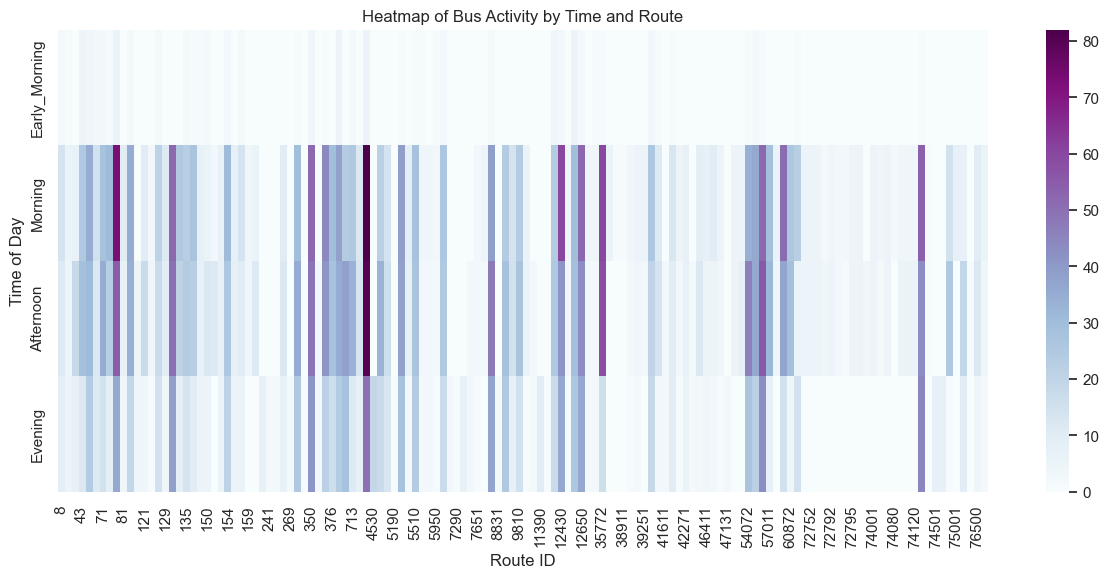

In [44]:
# Heatmap of Bus Activity by Time and Route
merged_final_data['route_id_run'] = merged_final_data['route_id_run'].astype(float).astype(int)
merged_final_data.sort_values('route_id_run', inplace=True)
time_route_heatmap_data = pd.crosstab(merged_final_data['time_cat'], merged_final_data['route_id_run'])
time_route_heatmap_data = pd.crosstab(merged_final_data['time_cat'], merged_final_data['route_id_run'])
plt.figure(figsize=(15, 6))
sns.heatmap(time_route_heatmap_data, annot=False, fmt="d", cmap="BuPu")
plt.title('Heatmap of Bus Activity by Time and Route')
plt.xlabel('Route ID')
plt.ylabel('Time of Day')
plt.grid(True)
plt.show()

In [45]:
merged_final_data = merged_final_data[merged_final_data['total_distance_km'] > 0]
merged_final_data.columns

Index(['trip_duration', 'run_duration_minutes', 'busid', 'route_id_run',
       'triplog_id', 'total_distance_km', 'total_charging_time_sec', 'speed',
       'rightctrl_temp', 'rightmotor_windingtemp', 'leftmotor_windingtemp',
       'total_current', 'gears', 'total_mileage', 'brakepedal_status',
       'handbrake_status', 'soc', 'direction_deg', 'leftmotor_workingmode',
       'reversing_light', 'stoplight', 'charge_status', 'door1_status',
       'dipped_headlight', 'ns_direction', 'rightctrl_radiatortemp',
       'total_voltage', 'door2_status', 'leftmotor_rpm', 'leftctrl_temp',
       'leftctrl_radiatortemp', 'left_trunlight', 'front_foglamp',
       'speed_onwheel', 'ew_direction', 'local_time', 'rightmotor_workingmode',
       'headlight', 'right_trunlight', 'redis_time', 'ac_switch',
       'speaker_status', 'outside_car_temperature', 'inside_car_temperature',
       'ac_workmode', 'ac_set_temperature', 'acceleration_pedal',
       'change_info', 'depart_interval', 'from_station

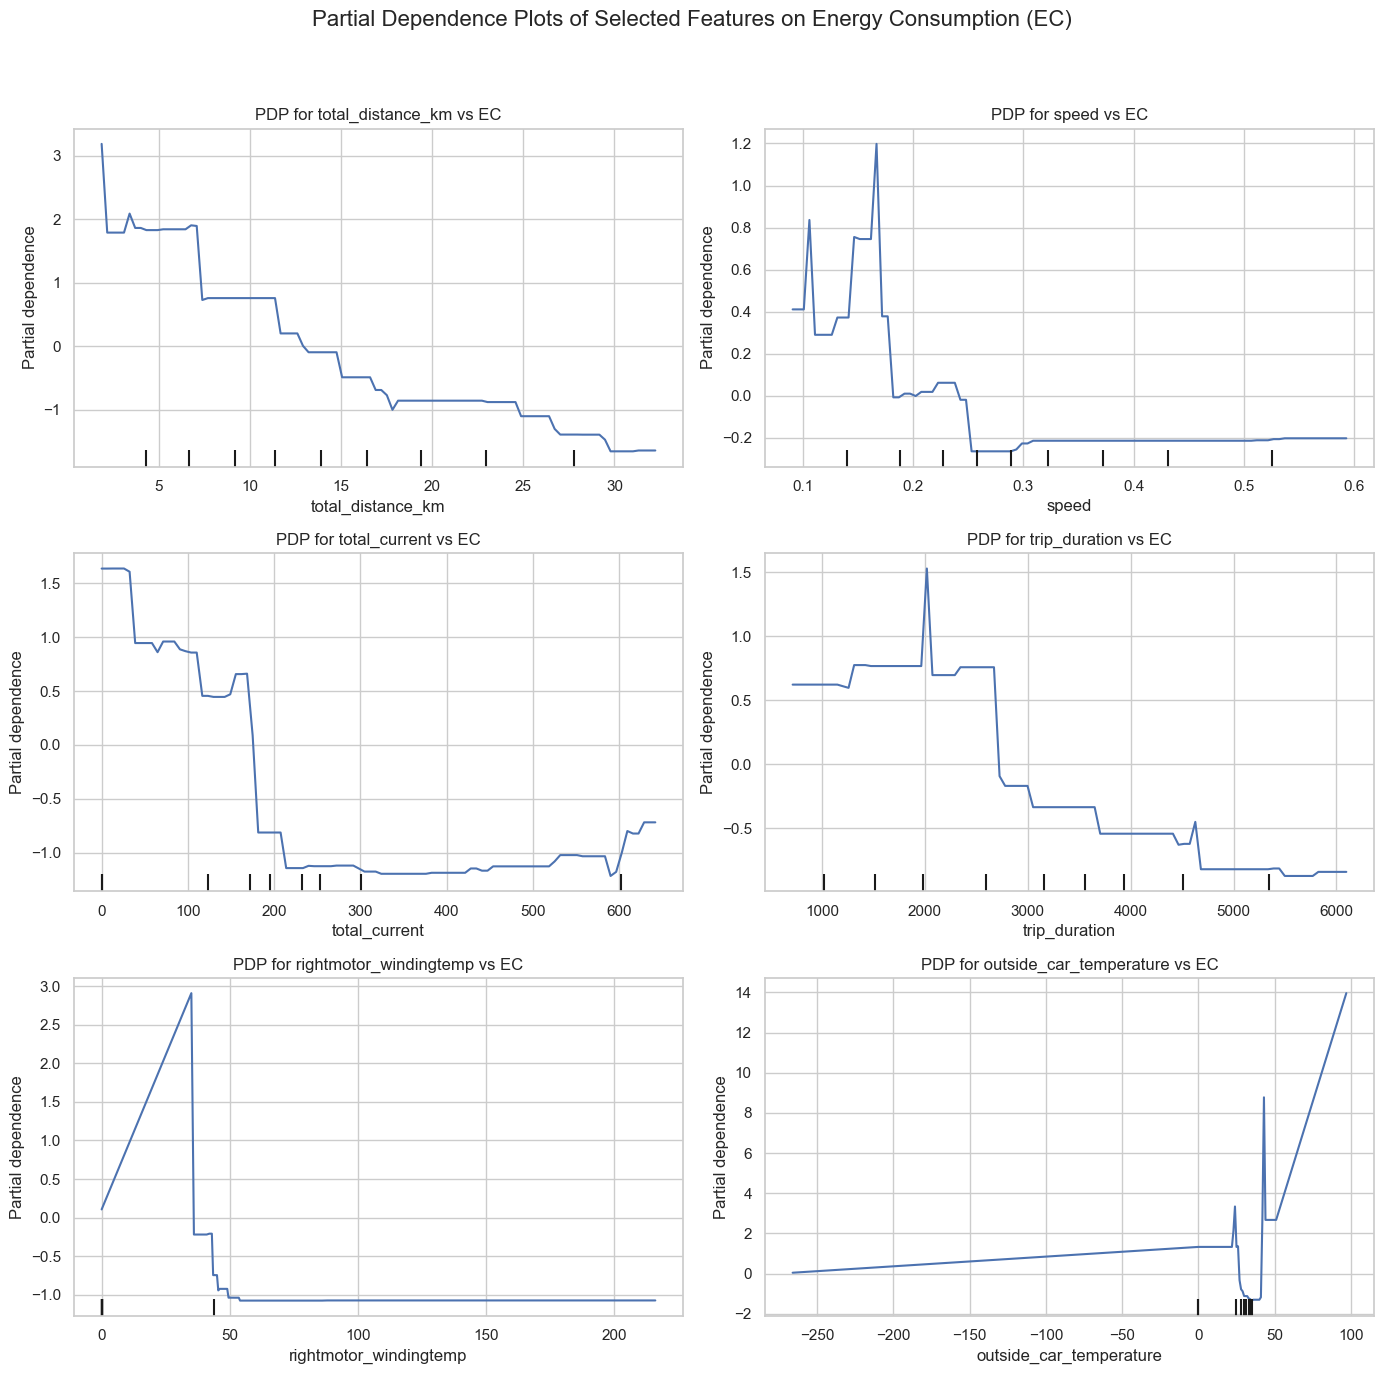

In [46]:
features = ['total_distance_km','speed','total_current','trip_duration','rightmotor_windingtemp', 'outside_car_temperature']
merged_final_data.dropna(subset=features, inplace=True)

model = GradientBoostingRegressor(random_state=0)
model.fit(merged_final_data[features], merged_final_data['ec'])

fig, ax = plt.subplots(3, 2, figsize=(14, 14))
for i, feature in enumerate(features):
    axi = ax[i // 2, i % 2]
    display = PartialDependenceDisplay.from_estimator(model, merged_final_data[features], features=[feature], ax=axi, feature_names=features)
    axi.set_title(f'PDP for {feature} vs EC')

plt.suptitle('Partial Dependence Plots of Selected Features on Energy Consumption (EC)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


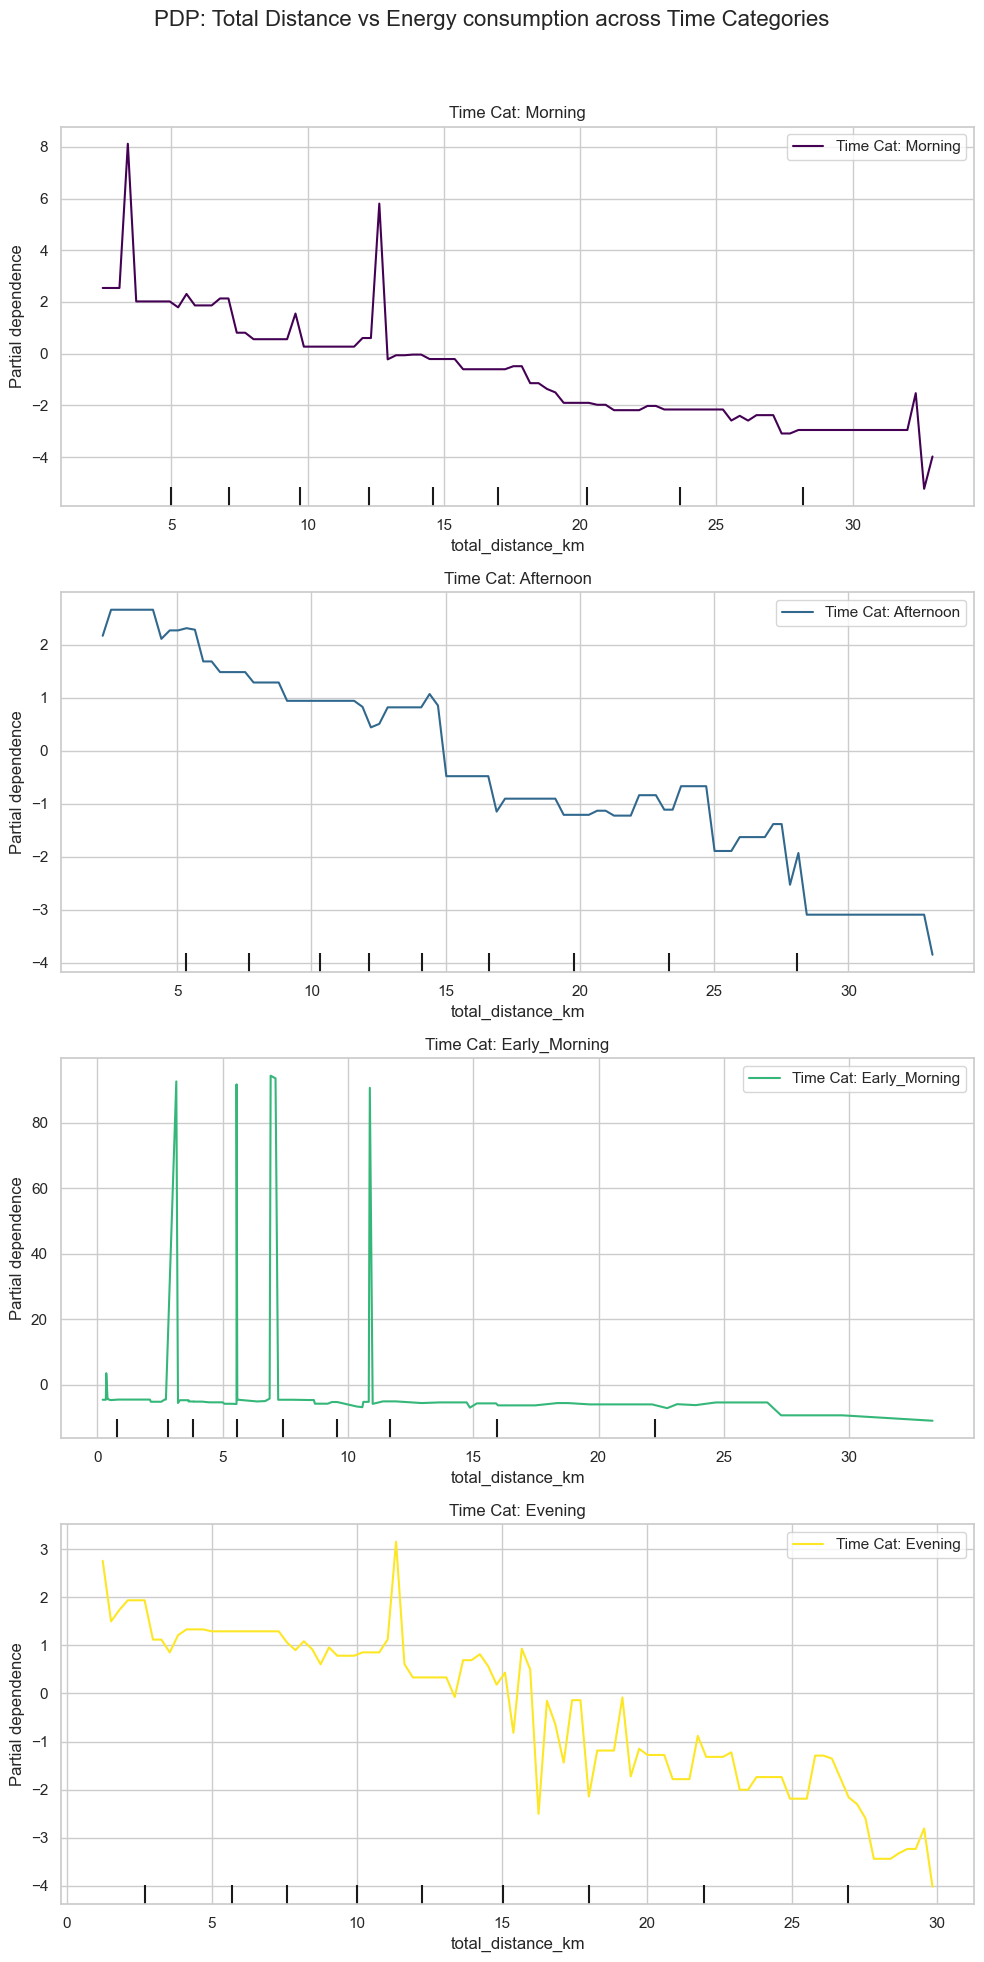

In [47]:
feature_to_plot ="total_distance_km"
merged_final_data.dropna(subset=[feature_to_plot], inplace=True)
n_categories = len(merged_final_data['time_cat'].unique())
fig, axes = plt.subplots(n_categories, 1, figsize=(10, 5 * n_categories))
if n_categories == 1: axes = [axes]
time_categories = merged_final_data['time_cat'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(time_categories)))

for ax, time_cat, color in zip(axes, time_categories, colors):
    subset_data = merged_final_data[merged_final_data['time_cat'] == time_cat]
    model = GradientBoostingRegressor(random_state=0)
    model.fit(subset_data[[feature_to_plot]], subset_data['ec'])
    
    display = PartialDependenceDisplay.from_estimator(
        model,
        subset_data[[feature_to_plot]],
        features=[0],
        ax=ax,
        feature_names=[feature_to_plot],
        line_kw={"color": color, "label": f'Time Cat: {time_cat}'}
    )
    ax.set_title(f'Time Cat: {time_cat}')
    ax.legend()

fig.suptitle('PDP: Total Distance vs Energy consumption across Time Categories', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [48]:
merged_final_data.to_csv('final_aggregated_data.csv', index=False)

# Visualize trips

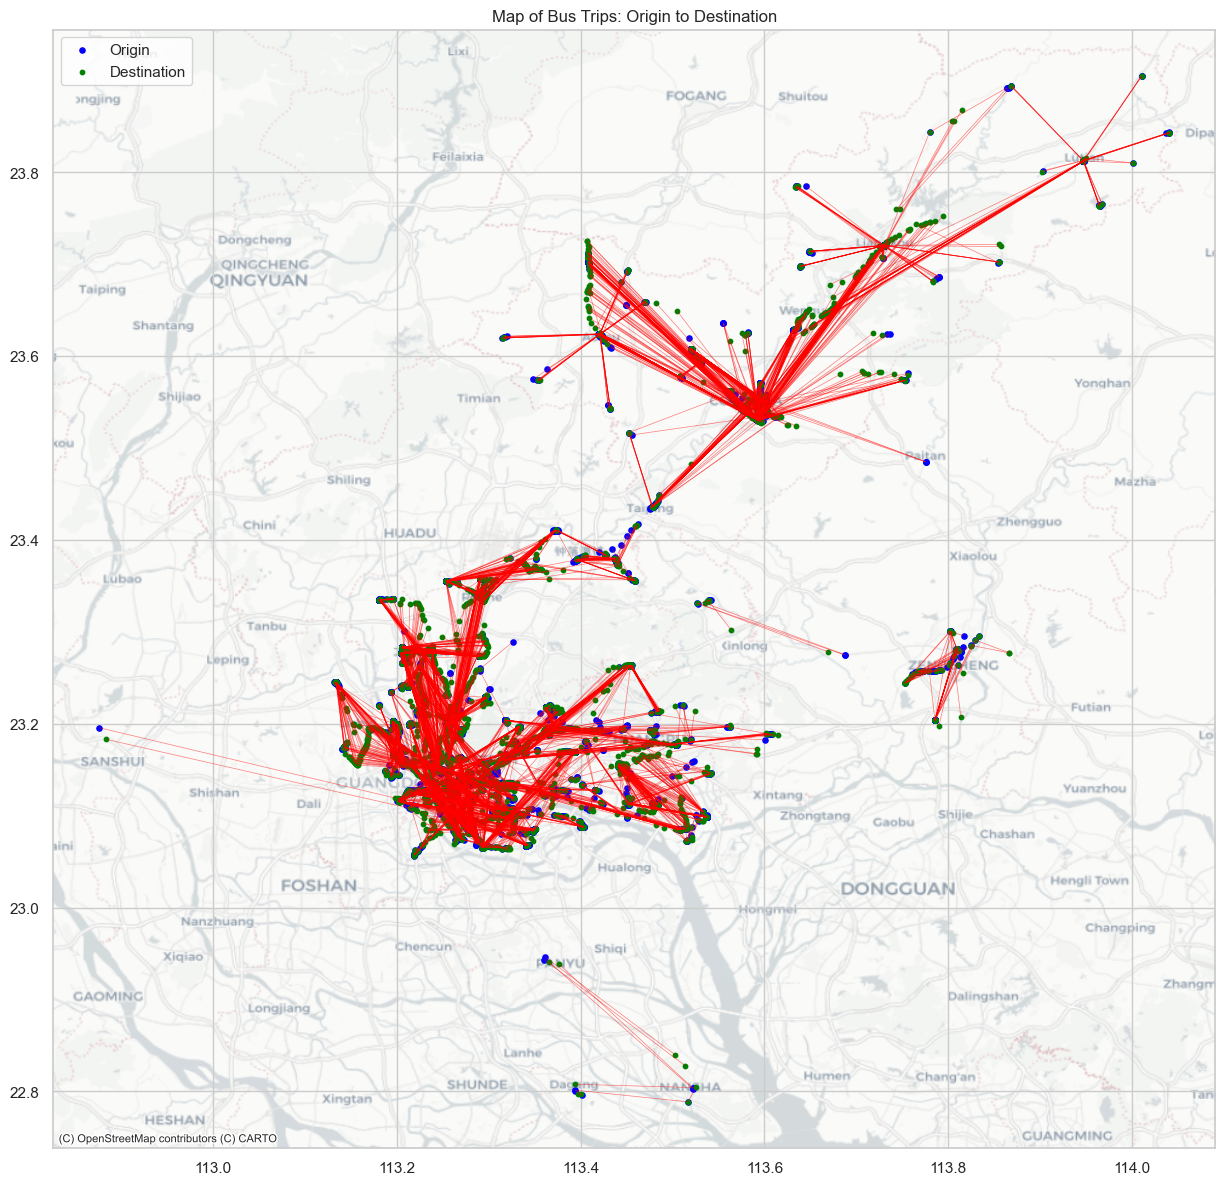

In [51]:
#Plot new data trips
gdf_origins = gpd.GeoDataFrame(
    merged_final_data,
    geometry=gpd.points_from_xy(merged_final_data.longitude_origin, merged_final_data.latitude_origin),
    crs="EPSG:4326")

gdf_destinations = gpd.GeoDataFrame(
    merged_final_data,
    geometry=gpd.points_from_xy(merged_final_data.longitude_destination, merged_final_data.latitude_destination),
    crs="EPSG:4326")

gdf_trips = gpd.GeoDataFrame(
    merged_final_data,
    geometry=[LineString([Point(xy1), Point(xy2)]) for xy1, xy2 in zip(
        zip(merged_final_data.longitude_origin, merged_final_data.latitude_origin),
        zip(merged_final_data.longitude_destination, merged_final_data.latitude_destination)
    )],
    crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(15, 15))
gdf_trips.plot(ax=ax, linewidth=0.5, alpha=0.5, color='red')
gdf_origins.plot(ax=ax, markersize=14, color='blue', label='Origin')
gdf_destinations.plot(ax=ax, markersize=10, color='green', label='Destination')
ctx.add_basemap(ax, crs=gdf_trips.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_xlim([merged_final_data.longitude_origin.min() - 0.05, merged_final_data.longitude_destination.max() + 0.05])
ax.set_ylim([merged_final_data.latitude_origin.min() - 0.05, merged_final_data.latitude_destination.max() + 0.05])
ax.set_title('Map of Bus Trips: Origin to Destination')
ax.legend()
fig.savefig("OD_trips.png", dpi=300)
plt.show()